In [19]:
"""
This notebook deconstructs the modern era satellite observations of basal melt from Paolo et al (2023) to obtain a 
draft dependence parameterization after removing the linear and seasonal trends. 
"""

import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose



import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

dask.config.set(malloc_hook='jemalloc')

# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51557 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:51557/status,
Dashboard: http://127.0.0.1:51557/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51558,Workers: 5
Dashboard: http://127.0.0.1:51557/status,Total threads: 10
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:51571,Total threads: 2
Dashboard: http://127.0.0.1:51580/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:51561,


# Read dataset

In [20]:
# File path directories

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent

DIR_external = 'data/external/'
DIR_processed = 'data/processed/'

FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_melt_detrend_deseasonalize = "obs23_melt_detrend_uniform_deseasonalize_uniform.nc"

FILE_iceShelvesShape = 'iceShelves.geojson'
ICESHELVES_MASK = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs, chunks={"x":729, "y":729})
obs23_melt = MELTDRAFT_OBS.melt
obs23_draft = MELTDRAFT_OBS.draft

obs23_melt_detrend_uniform_deseasonalize_uniform = xr.open_dataset(main_dir / DIR_processed / FILE_melt_detrend_deseasonalize, chunks={"x":729, "y":729})
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.melt

# Time series of spatial mean melt
obs23_melt_ts = obs23_melt.mean(dim=['x', 'y']).compute()
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim=['x', 'y']).compute()

# Time mean of melt rate and draft
obs23_melt_tm = obs23_melt.mean(dim='time').compute()
obs23_draft_tm = obs23_draft.mean(dim='time').compute()

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [22]:
obs23_melt_mean = obs23_melt.mean().compute()

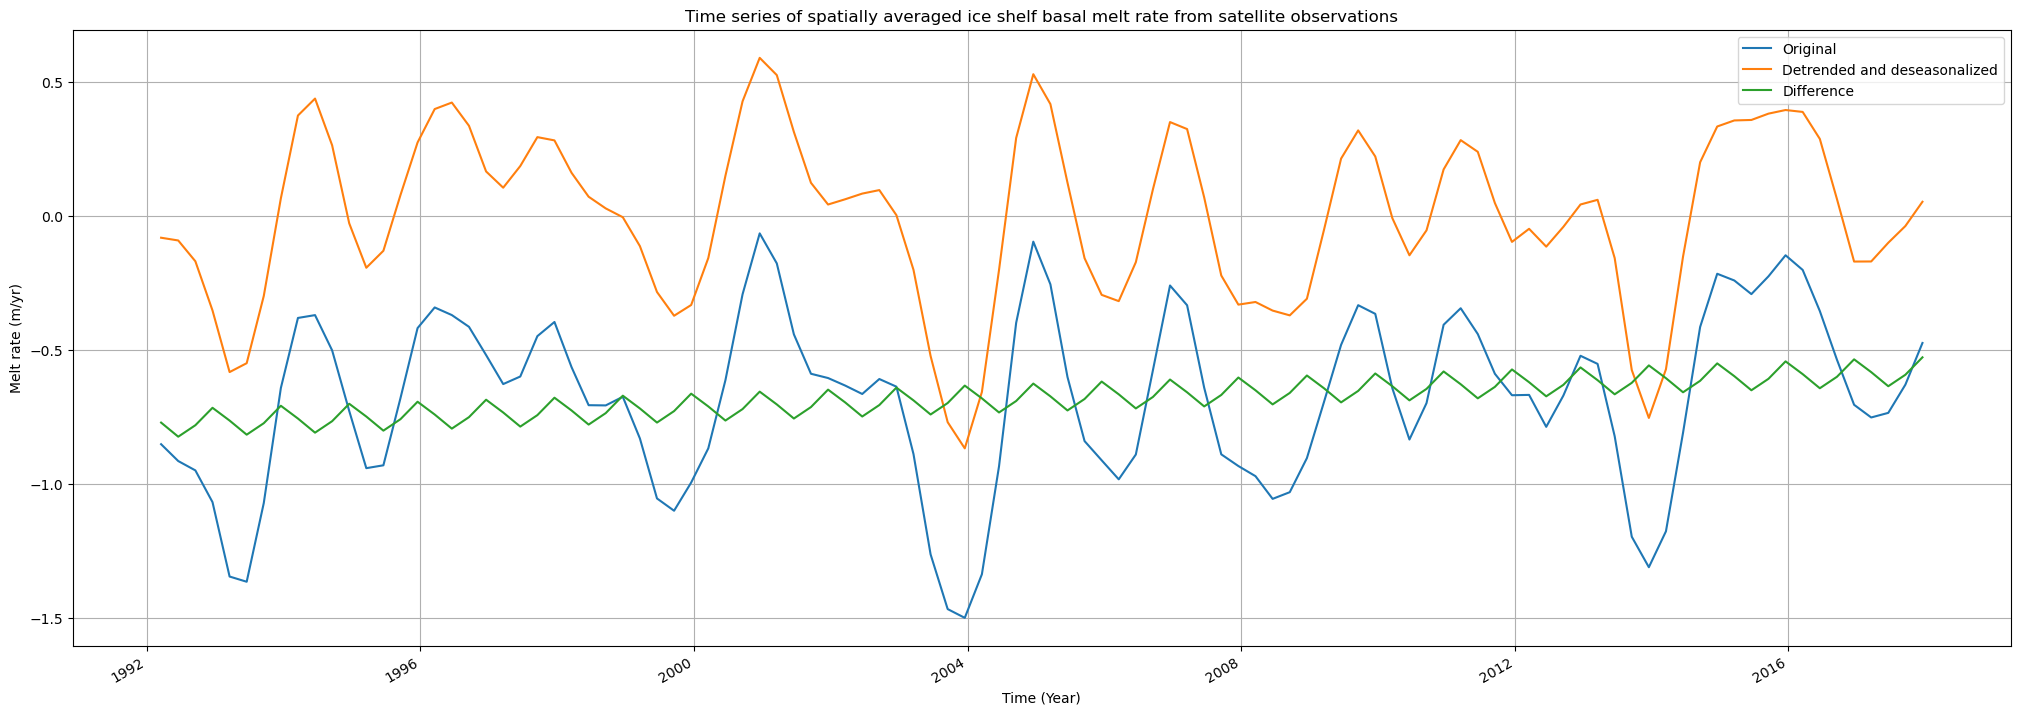

In [24]:
plt.figure(figsize=(25,8))
obs23_melt_ts.plot()
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot()
(obs23_melt_ts - obs23_melt_detrend_uniform_deseasonalize_uniform_ts).plot()
#plt.axhline(obs23_melt_mean, color='k', linestyle='--')
#(obs23_melt_detrend_uniform_deseasonalize_uniform_ts+obs23_melt_mean).plot()
plt.legend(['Original', 'Detrended and deseasonalized', 'Difference'])
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations')
plt.ylabel('Melt rate (m/yr)')
plt.xlabel('Time (Year)')
plt.grid()

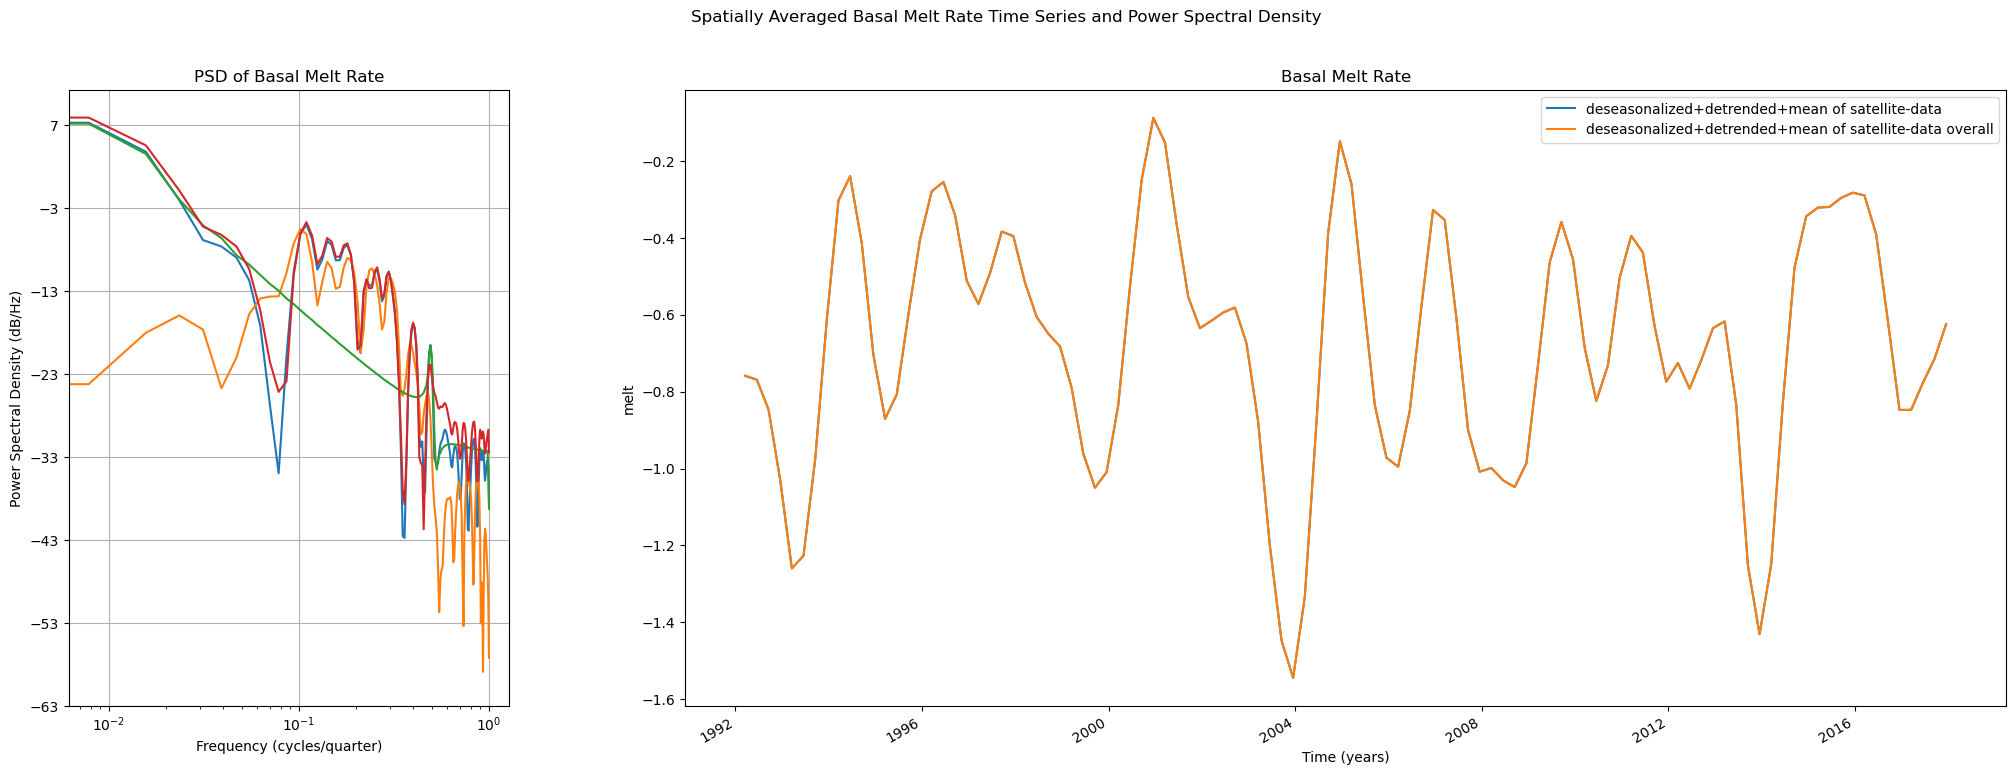

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(obs23_melt_ts);
axs[0].psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
axs[0].psd(obs23_melt_ts - obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
axs[0].psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts+obs23_melt_mean);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

obs23_melt_ts.plot(ax=axs[1], label='raw-satellite-data')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-detrended-satellite-data')
(obs23_melt_ts - obs23_melt_detrend_uniform_deseasonalize_uniform_ts).plot(ax=axs[1], label='seasonality+trend of satellite-data')
(obs23_melt_detrend_uniform_deseasonalize_uniform_ts+obs23_melt_mean).plot(ax=axs[1], label='deseasonalized+detrended+mean of satellite-data')
obs23_melt_detrend_deseasonalize_mean_sum_ts.plot(ax=axs[1], label='deseasonalized+detrended+mean of satellite-data overall')
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

In [20]:
obs23_melt_detrend_deseasonalize_mean_sum = obs23_melt_detrend_uniform_deseasonalize_uniform + obs23_melt_mean

In [42]:
obs23_melt_mean

<xarray.DataArray 'melt' ()>
array(-0.6781002, dtype=float32)

In [28]:
obs23_melt_detrend_uniform_deseasonalize_uniform.rio.write_crs("epsg:3031",inplace=True);
#obs23_melt_detrend_deseasonalize_mean_sum.rio.write_crs("epsg:3031",inplace=True);
obs23_draft.rio.write_crs("epsg:3031",inplace=True);

In [30]:
# The draft dependent parameterization is calculated on the (raw - linear trend - seasonal trend + mean) data

iceShelfRegions = range(33,133)

def dedraft(data, draft):
    data_tm = data.mean(dim='time')
    draft_tm = draft.mean(dim='time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    #data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    #data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    #data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    #data_pred = data_pred_stack.unstack('z').transpose()
    #data_dedraft = data - data_pred
    return reg.coef_, reg.intercept_#, data_pred, data_dedraft


for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = clip_data(obs23_melt_detrend_deseasonalize_mean_sum, i)
    h = clip_data(obs23_draft, i)
    mlt_tm = mlt.mean(dim='time')
    h_tm = h.mean(dim='time')
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_coef, mlt_intercept = dedraft(mlt, h)

    mlt_coef_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_coef)
    mlt_intercept_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_intercept)
    mlt_coef_ds = xr.DataArray(mlt_coef_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_intercept_ds = xr.DataArray(mlt_intercept_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_coef_ds.rio.write_crs("epsg:3031",inplace=True);
    mlt_intercept_ds.rio.write_crs("epsg:3031",inplace=True);
    # Create a boolean mask for the ice shelf of interest using the icems geometry
    # # This mask will be used to filter the two data arrays above to define values only inside the ice shelf mask region
    ice_shelf_mask = icems.loc[[i],'geometry'].apply(mapping)
    # Filter the mlt_coef_ds data array using this mask
    mlt_coef_ds = mlt_coef_ds.rio.clip(ice_shelf_mask,icems.crs)
    mlt_intercept_ds = mlt_intercept_ds.rio.clip(ice_shelf_mask,icems.crs)
    
    mlt_coef_ds.name = 'draftDepenBasalMeltAlpha1'
    mlt_coef_ds.attrs['long_name'] = 'Basal melt rate draft dependency coefficient (alpha1 or slope)'
    mlt_coef_ds.attrs['units'] = 'm/yr/m'

    mlt_intercept_ds.name = 'draftDepenBasalMeltAlpha0'
    mlt_intercept_ds.attrs['long_name'] = 'Basal melt rate draft dependency coefficient (alpha0 or intercept)'
    mlt_intercept_ds.attrs['units'] = 'm/yr'
    
    # Save mlt_coef_ds and mlt_intercept_ds data arrays to a single xarray dataset
    mlt_coefs = xr.Dataset({'draftDepenBasalMeltAlpha1': mlt_coef_ds, 'draftDepenBasalMeltAlpha0': mlt_intercept_ds})

    mlt_coefs.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23_with_mean/draftDepenBasalMeltAlpha_{}.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))
    del mlt, h, mlt_tm, h_tm, mlt_coef, mlt_intercept, mlt_coef_ds, mlt_intercept_ds, ice_shelf_mask, mlt_coefs
    print('deleted interim variables')
    gc.collect()

extracting data for catchment Abbot
calculating linear regression for catchment Abbot
Abbot file saved
deleted interim variables
extracting data for catchment Amery
calculating linear regression for catchment Amery
Amery file saved
deleted interim variables
extracting data for catchment Atka
calculating linear regression for catchment Atka
Atka file saved
deleted interim variables
extracting data for catchment Aviator
calculating linear regression for catchment Aviator
Aviator file saved
deleted interim variables
extracting data for catchment Bach
calculating linear regression for catchment Bach
Bach file saved
deleted interim variables
extracting data for catchment Baudouin
calculating linear regression for catchment Baudouin
Baudouin file saved
deleted interim variables
extracting data for catchment Borchgrevink
calculating linear regression for catchment Borchgrevink
Borchgrevink file saved
deleted interim variables
extracting data for catchment Brahms
calculating linear regression 

In [31]:

iceShelfRegions = range(33,133)
ds = xr.Dataset()
for i in iceShelfRegions:
    ds = xr.merge([ds, xr.open_dataset(main_dir / DIR_processed / 'draft_dependence_params/Paolo23_with_mean/draftDepenBasalMeltAlpha_{}.nc'.format(icems.name.values[i]))])

ds.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23_with_mean/draftDepenBasalMeltAlpha.nc')

In [40]:
obs23_draft_dependent_melt = (obs23_draft_tm * ds.draftDepenBasalMeltAlpha1) + ds.draftDepenBasalMeltAlpha0

In [6]:
ds = xr.open_dataset(main_dir / DIR_processed / 'draft_dependence_params/Paolo23_with_mean/draftDepenBasalMeltAlpha.nc')

In [8]:
ds_filled = ds.fillna(0)

In [11]:
ds_filled.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23_with_mean/draftDepenBasalMeltAlpha_noNaN.nc')

In [16]:
ds_filled = ds_filled.rename({'x': 'x1', 'y': 'y1'})



In [18]:
ds_filled.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23_with_mean/draftDepenBasalMeltAlpha_noNaN.nc')

In [25]:
# Helper functions

def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

def find_ice_shelf_index(ice_shelf_name):
    return icems[icems['name']==ice_shelf_name].index[0]

def deseasonalize(data):
    data_month = data.groupby("time.month")
    data_clm = data_month.mean("time") # Climatologies
    data_anm = data_month - data_clm # Deseasonalized anomalies
    return data_anm

In [29]:
# The draft dependent parameterization is calculated on the (raw - linear trend - seasonal trend + mean) data

iceShelfRegions = range(33,133)

def dedraft(data, draft):
    data_tm = data.mean(dim='time')
    draft_tm = draft.mean(dim='time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    data_pred = data_pred_stack.unstack('z').transpose()
    #data_dedraft = data - data_pred
    return data_pred # reg.coef_, reg.intercept_, data_dedraft


for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform, i)
    h = clip_data(obs23_draft, i)
    mlt_tm = mlt.mean(dim='time')
    h_tm = h.mean(dim='time')
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_pred = dedraft(mlt, h)

    mlt_pred_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_pred)
    mlt_pred_ds = xr.DataArray(mlt_pred_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_pred_ds.rio.write_crs("epsg:3031",inplace=True);
    # Create a boolean mask for the ice shelf of interest using the icems geometry
    # # This mask will be used to filter the two data arrays above to define values only inside the ice shelf mask region
    ice_shelf_mask = icems.loc[[i],'geometry'].apply(mapping)
    # Filter the mlt_coef_ds data array using this mask
    mlt_pred_ds = mlt_pred_ds.rio.clip(ice_shelf_mask,icems.crs)
    
    mlt_pred_ds.name = 'draftDepenBasalMeltPred'
    mlt_pred_ds.attrs['long_name'] = 'Basal melt rate draft dependence prediction, i.e., draft component of melt rate (m/yr)'
    mlt_pred_ds.attrs['units'] = 'm/yr'
    
    # Save mlt_coef_ds and mlt_intercept_ds data arrays to a single xarray dataset
    # Save mlt_pred_ds data array to a single xarray dataset
    mlt_pred_data = xr.Dataset({'draftDepenBasalMeltPred': mlt_pred_ds})

    mlt_pred_data.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/draftDepenPrediction/draftDepenBasalMeltPred_{}.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))
    del mlt, h, mlt_tm, h_tm, mlt_pred, mlt_pred_ds, ice_shelf_mask, mlt_pred_data
    print('deleted interim variables')
    gc.collect()

extracting data for catchment Abbot
calculating linear regression for catchment Abbot
Abbot file saved
deleted interim variables
extracting data for catchment Amery
calculating linear regression for catchment Amery
Amery file saved
deleted interim variables
extracting data for catchment Atka
calculating linear regression for catchment Atka
Atka file saved
deleted interim variables
extracting data for catchment Aviator
calculating linear regression for catchment Aviator
Aviator file saved
deleted interim variables
extracting data for catchment Bach
calculating linear regression for catchment Bach
Bach file saved
deleted interim variables
extracting data for catchment Baudouin
calculating linear regression for catchment Baudouin
Baudouin file saved
deleted interim variables
extracting data for catchment Borchgrevink
calculating linear regression for catchment Borchgrevink
Borchgrevink file saved
deleted interim variables
extracting data for catchment Brahms
calculating linear regression 

In [30]:

iceShelfRegions = range(33,133)
ds = xr.Dataset()
for i in iceShelfRegions:
    ds = xr.merge([ds, xr.open_dataset(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/draftDepenPrediction/draftDepenBasalMeltPred_{}.nc'.format(icems.name.values[i]))])

ds.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/draftDepenPrediction/draftDepenBasalMeltPrediction.nc')

In [32]:
obs23_draft_dependent_melt_prediction = ds.draftDepenBasalMeltPred

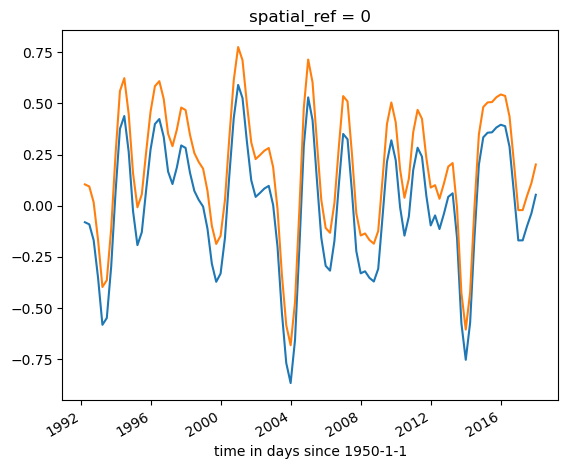

In [48]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot()
obs23_melt_detrend_uniform_deseasonalize_uniform_dedraft_ts.plot()

In [43]:
obs23_melt_detrend_uniform_deseasonalize_uniform_dedraft = obs23_melt_detrend_uniform_deseasonalize_uniform - obs23_draft_dependent_melt_prediction

In [45]:
obs23_melt_detrend_uniform_deseasonalize_uniform_dedraft_ts = obs23_melt_detrend_uniform_deseasonalize_uniform_dedraft.mean(dim=['x', 'y']).compute()

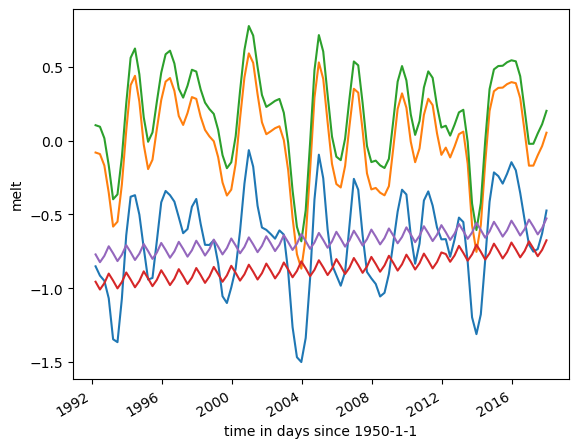

In [53]:
obs23_melt_ts.plot()
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot()
obs23_melt_detrend_uniform_deseasonalize_uniform_dedraft_ts.plot()
(obs23_melt_ts-obs23_melt_detrend_uniform_deseasonalize_uniform_dedraft_ts).plot()


In [ ]:
total_melt = trend + seasonality + draft_dependence + variability

force the ice sheet model with mean melt rate based on draft dependence, i.e.,

draft_dependence + (total_melt - draft_pred)


In [ ]:
# floatingBasalMassBalAdjustment

obs23_melt_tm - obs23_draft_dependent_melt_prediction 

In [54]:
obs23_melt_detrend_uniform_deseasonalize_uniform - obs23_draft_dependent_melt_prediction + obs23_melt_tm

<xarray.DataArray 'melt' ()>
array(-0.6965382, dtype=float32)

In [65]:
# melt rate adjustment for the draftDepen simulation
obs23_melt_tm_dedraft = obs23_melt_tm - obs23_draft_dependent_melt_prediction


In [71]:
# Name the data array obs23_melt_tm_dedraft
obs23_melt_tm_dedraft.name = 'meltRateDraftDepenAdjustment'
obs23_melt_tm_dedraft.attrs['long_name'] = 'Basal melt rate adjustment for draft dependence simulation, i.e., mean melt rate with draft dependence prediction subtracted out'
obs23_melt_tm_dedraft.attrs['units'] = 'm/yr'

In [73]:
obs23_melt_tm_dedraft.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/meltRateDraftDepenAdjustment.nc')

In [74]:
obs23_melt_tm_dedraft_noNaN = obs23_melt_tm_dedraft.fillna(0)




In [1]:
obs23_melt_tm_dedraft_noNaN

NameError: name 'obs23_melt_tm_dedraft_noNaN' is not defined

In [78]:
obs23_melt_tm_dedraft_noNaN = obs23_melt_tm_dedraft_noNaN.rename({'x': 'x1', 'y': 'y1'})

In [79]:
obs23_melt_tm_dedraft_noNaN.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/meltRateDraftDepenAdjustment_noNaN.nc')

In [66]:
obs23_melt_tm_dedraft_vmin = np.nanquantile(obs23_melt_tm_dedraft.values, 0.01)
obs23_melt_tm_dedraft_vmax = np.nanquantile(obs23_melt_tm_dedraft.values, 0.99)

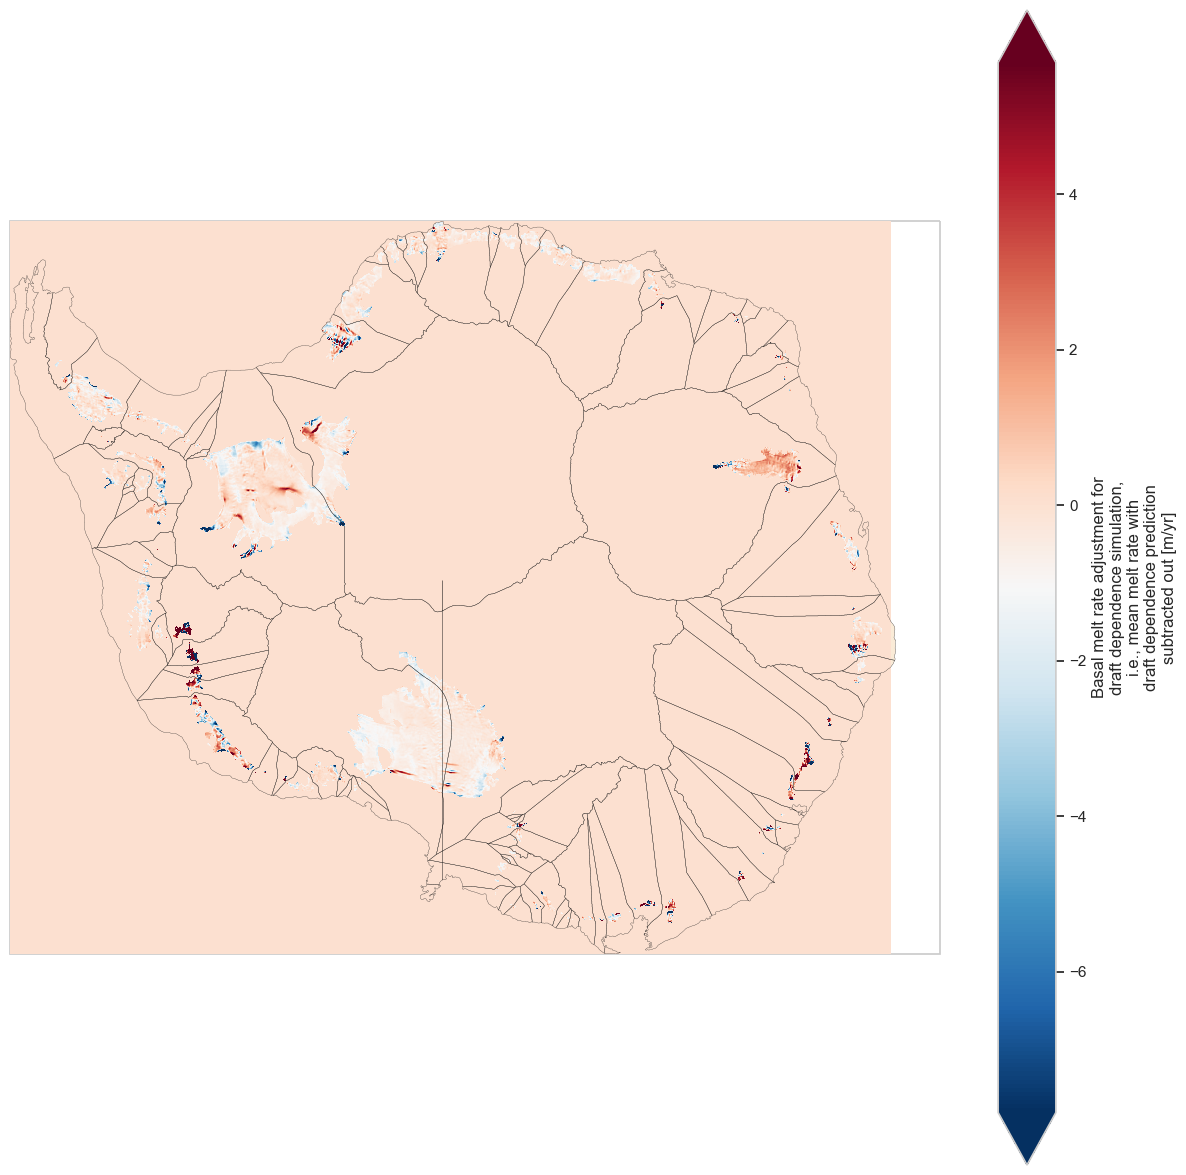

In [76]:

sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

icems[33:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[33:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=7)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)

obs23_melt_tm_dedraft_noNaN.plot(ax=ax1, zorder=4, cmap='RdBu_r', add_colorbar=True, vmin = obs23_melt_tm_dedraft_vmin, vmax = obs23_melt_tm_dedraft_vmax)

In [83]:
scaleFactor = 910.0/(3600.0*24.0*365.0)

In [84]:
# Convert all sat obs dataset of melt rates from m/yr to kg/m^2/s

obs23_melt_SI = obs23_melt * scaleFactor
obs23_melt_detrend_uniform_deseasonalize_uniform_SI = obs23_melt_detrend_uniform_deseasonalize_uniform * scaleFactor


In [86]:
# Draft dependent melt rate of detrended deseasonalized sat obs data in kg/m^2/s

# The draft dependent parameterization is calculated on the (raw - linear trend - seasonal trend + mean) data

iceShelfRegions = range(33,133)

def dedraft(data, draft):
    data_tm = data.mean(dim='time')
    draft_tm = draft.mean(dim='time')
    data_stack = data_tm.stack(z=('x', 'y'))
    draft_stack = draft_tm.stack(z=('x', 'y'))
    data_stack_noNaN = data_stack.fillna(0)
    draft_stack_noNaN = draft_stack.fillna(0)
    data_stack_noNaN_vals = data_stack_noNaN.values.reshape(-1,1)
    draft_stack_noNaN_vals = draft_stack_noNaN.values.reshape(-1,1)
    reg = LinearRegression().fit(draft_stack_noNaN_vals, data_stack_noNaN_vals)
    data_pred_stack_noNaN_vals = reg.predict(draft_stack_noNaN_vals).reshape(-1)
    data_pred_stack_noNaN = data_stack_noNaN.copy(data=data_pred_stack_noNaN_vals)
    data_pred_stack = data_pred_stack_noNaN.where(~data_stack.isnull(), np.nan)
    data_pred = data_pred_stack.unstack('z').transpose()
    #data_dedraft = data - data_pred
    return reg.coef_, reg.intercept_, data_pred #, data_dedraft


for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mlt = clip_data(obs23_melt_detrend_uniform_deseasonalize_uniform_SI, i)
    h = clip_data(obs23_draft, i)
    mlt_tm = mlt.mean(dim='time')
    h_tm = h.mean(dim='time')
    print('calculating linear regression for catchment {}'.format(icems.name.values[i]))
    mlt_coef, mlt_intercept, mlt_pred = dedraft(mlt, h)

    mlt_coef_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_coef)
    mlt_intercept_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_intercept)
    mlt_pred_ds = np.full((mlt_tm.shape[0], mlt_tm.shape[1]), mlt_pred)

    mlt_coef_ds = xr.DataArray(mlt_coef_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_intercept_ds = xr.DataArray(mlt_intercept_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})
    mlt_pred_ds = xr.DataArray(mlt_pred_ds, dims=['y', 'x'], coords={'x': mlt_tm.x, 'y': mlt_tm.y})    
    
    mlt_coef_ds.rio.write_crs("epsg:3031",inplace=True);
    mlt_intercept_ds.rio.write_crs("epsg:3031",inplace=True);
    mlt_pred_ds.rio.write_crs("epsg:3031",inplace=True);

    # Create a boolean mask for the ice shelf of interest using the icems geometry
    # # This mask will be used to filter the two data arrays above to define values only inside the ice shelf mask region
    ice_shelf_mask = icems.loc[[i],'geometry'].apply(mapping)
    # Filter the mlt_coef_ds data array using this mask
    mlt_coef_ds = mlt_coef_ds.rio.clip(ice_shelf_mask,icems.crs)
    mlt_intercept_ds = mlt_intercept_ds.rio.clip(ice_shelf_mask,icems.crs)
    mlt_pred_ds = mlt_pred_ds.rio.clip(ice_shelf_mask,icems.crs)
    
    mlt_coef_ds.name = 'draftDepenBasalMeltAlpha1'
    mlt_coef_ds.attrs['long_name'] = 'Basal melt rate draft dependency coefficient (alpha1 or slope)'
    mlt_coef_ds.attrs['units'] = 'kg/m/s'

    mlt_intercept_ds.name = 'draftDepenBasalMeltAlpha0'
    mlt_intercept_ds.attrs['long_name'] = 'Basal melt rate draft dependency coefficient (alpha0 or intercept)'
    mlt_intercept_ds.attrs['units'] = 'kg/m^2/s'

    mlt_pred_ds.name = 'draftDepenBasalMeltPred'
    mlt_pred_ds.attrs['long_name'] = 'Basal melt rate draft dependence prediction, i.e., draft component of melt rate (kg/m^2/s)'
    mlt_pred_ds.attrs['units'] = 'kg/m^2/s'

    # Save mlt_coef_ds and mlt_intercept_ds data arrays to a single xarray dataset
    mlt_coefs = xr.Dataset({'draftDepenBasalMeltAlpha1': mlt_coef_ds, 'draftDepenBasalMeltAlpha0': mlt_intercept_ds})
    mlt_pred_data = xr.Dataset({'draftDepenBasalMeltPred': mlt_pred_ds})

    mlt_coefs.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/units_SI/draftDepenParams/draftDepenBasalMeltAlpha_{}.nc'.format(icems.name.values[i]))
    mlt_pred_data.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/units_SI/draftDepenPrediction/draftDepenBasalMeltPred_{}.nc'.format(icems.name.values[i]))
    print('{} file saved'.format(icems.name.values[i]))
    del mlt, h, mlt_tm, h_tm, mlt_coef, mlt_intercept, mlt_pred, mlt_coef_ds, mlt_intercept_ds, mlt_pred_ds, ice_shelf_mask, mlt_coefs, mlt_pred_data
    print('deleted interim variables')
    gc.collect()

extracting data for catchment Abbot
calculating linear regression for catchment Abbot
Abbot file saved
deleted interim variables
extracting data for catchment Amery
calculating linear regression for catchment Amery
Amery file saved
deleted interim variables
extracting data for catchment Atka
calculating linear regression for catchment Atka
Atka file saved
deleted interim variables
extracting data for catchment Aviator
calculating linear regression for catchment Aviator
Aviator file saved
deleted interim variables
extracting data for catchment Bach
calculating linear regression for catchment Bach
Bach file saved
deleted interim variables
extracting data for catchment Baudouin
calculating linear regression for catchment Baudouin
Baudouin file saved
deleted interim variables
extracting data for catchment Borchgrevink
calculating linear regression for catchment Borchgrevink
Borchgrevink file saved
deleted interim variables
extracting data for catchment Brahms
calculating linear regression 

<xarray.Dataset>
Dimensions:                    (y1: 2381, x1: 2863)
Coordinates:
  * x1                         (x1) float64 -2.697e+06 -2.695e+06 ... 2.798e+06
  * y1                         (y1) float64 -2.328e+06 -2.326e+06 ... 2.242e+06
Data variables:
    spatial_ref                int64 0
    draftDepenBasalMeltAlpha1  (y1, x1) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    draftDepenBasalMeltAlpha0  (y1, x1) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [87]:

iceShelfRegions = range(33,133)
ds_params = xr.Dataset()
ds_pred = xr.Dataset()
for i in iceShelfRegions:
    ds_params = xr.merge([ds_params, xr.open_dataset(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/units_SI/draftDepenParams/draftDepenBasalMeltAlpha_{}.nc'.format(icems.name.values[i]))])
    ds_pred = xr.merge([ds_pred, xr.open_dataset(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/units_SI/draftDepenPrediction/draftDepenBasalMeltPred_{}.nc'.format(icems.name.values[i]))])

ds_params.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/units_SI/draftDepenBasalMeltAlpha.nc')
ds_pred.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/units_SI/draftDepenBasalMeltPrediction.nc')

In [88]:
# Remove NaNs

ds_params_filled = ds_params.fillna(0)
ds_pred_filled = ds_pred.fillna(0)

# Rename x and y dimensions to x1 and y1
ds_params_filled = ds_params_filled.rename({'x': 'x1', 'y': 'y1'})
ds_pred_filled = ds_pred_filled.rename({'x': 'x1', 'y': 'y1'})

ds_params_filled.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/units_SI/draftDepenBasalMeltAlpha_noNaN.nc')
ds_pred_filled.to_netcdf(main_dir / DIR_processed / 'draft_dependence_params/Paolo23/units_SI/draftDepenBasalMeltPrediction_noNaN.nc')

In [110]:
ds

<xarray.Dataset>
Dimensions:                  (x: 2863, y: 2381)
Coordinates:
  * x                        (x) float64 -2.697e+06 -2.695e+06 ... 2.798e+06
  * y                        (y) float64 -2.328e+06 -2.326e+06 ... 2.242e+06
Data variables:
    spatial_ref              int64 0
    draftDepenBasalMeltPred  (y, x) float32 nan nan nan nan ... nan nan nan nan

In [91]:
# melt rate adjustment for the draftDepen simulation
obs23_melt_SI_tm = obs23_melt_SI.mean(dim='Time').compute()
obs23_melt_tm_dedraft_SI_tm = obs23_melt_SI_tm - ds_pred_filled.draftDepenBasalMeltPred


MemoryError: Unable to allocate 211. TiB for an array with shape (2916, 2916, 2381, 2863) and data type float32

In [99]:
ds_params.draftDepenBasalMeltAlpha1.shape

(2381, 2863)